In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import seaborn as sns

from sklearn.model_selection import train_test_split
import seaborn as sns

exp_values = [
    'C(Pclass)',
    'C(Sex)',
    'C(Child)',
    'C(Embarked)', 
    'C(HasSib)',
    'C(HasParch)'
]
predict_value = 'Survived'
child_threthold = 16


def output_result(model, category_data, base_data):
    result = model.predict(category_data)
    with open('data/result.csv', 'w') as f:
        f.write('PassengerId,Survived\n')
        for r, pid in zip(result, base_data['PassengerId']):
            f.write('{},{}\n'.format(pid, str(int(r))))


def category_to_table(titanic, is_training_data=True):
    fomula = '+'.join(exp_values)
    if is_training_data:
        fomula = fomula + '+' + predict_value

    print('fomula:', fomula)

    c_df = patsy.dmatrix(fomula, data=titanic, return_type='dataframe')
    return c_df


def load_titanic_data(is_training_data=True):
    """
    データを読みこみ、
    必要なパラメータに絞る
    """
    def is_child(age):
        if pd.isnull(age):
            return False
        if age < child_threthold:
            return True
        return False
    
    titanic = None
    if is_training_data:
        titanic = pd.read_csv("data/train.csv")
    else:
        titanic = pd.read_csv("data/test.csv")

    if is_training_data:
        titanic = titanic.dropna(
            subset=['Age', 'Sex', 'Pclass']
        )
    titanic = titanic.assign(
        Child=titanic['Age'].map(is_child),
        HasSib = titanic['SibSp'].map(lambda x: x > 1),
        HasParch = titanic['Parch'].map(lambda x: x > 1)
    )
        
    return titanic


def hit_rate(predict, test):
    N = len(predict)
    hit = sum([1 if p == t else 0 for p, t in zip(predict, test)])
    return hit/N * 1.0


def main():
    titanic = load_titanic_data()
    titanic_category = category_to_table(titanic)

    x_columns = list(titanic_category.columns)
    x_columns.remove(predict_value)

    X_train, X_test, Y_train, Y_test = train_test_split(titanic[x_columns],
                                                        titanic[predict_value],
                                                        test_size=0.4,
                                                        random_state=0)

titanic_test = load_titanic_data(False)
test_data = category_to_table(titanic_test, False)

titanic = load_titanic_data()
titanic.head(2)

fomula: C(Pclass)+C(Sex)+C(Child)+C(Embarked)+C(HasSib)+C(HasParch)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Child,HasParch,HasSib
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,False,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,False,False


In [33]:
titanic_category = category_to_table(titanic)
x_columns = list(titanic_category.columns)
x_columns.remove(predict_value)
x_columns

fomula: C(Pclass)+C(Sex)+C(Child)+C(Embarked)+C(HasSib)+C(HasParch)+Survived


['Intercept',
 'C(Pclass)[T.2]',
 'C(Pclass)[T.3]',
 'C(Sex)[T.male]',
 'C(Child)[T.True]',
 'C(Embarked)[T.Q]',
 'C(Embarked)[T.S]',
 'C(HasSib)[T.True]',
 'C(HasParch)[T.True]']

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(titanic_category[x_columns],
                                                                                        titanic_category[predict_value],
                                                                                        test_size=0.4,
                                                                                        random_state=0)
train_user =set(X_train.index)

print(len(X_train), len(X_test))

training_titanic = titanic.query('PassengerId in @train_user')
test_titanic = titanic.query('PassengerId not in @train_user')

## データに偏りがないかを調べる
pd.concat([X_train.sum(), X_test.sum()], axis=1)

427 285


,0,1
Intercept,427.0,285.0
C(Pclass)[T.2],106.0,67.0
C(Pclass)[T.3],219.0,136.0
C(Sex)[T.male],277.0,176.0
C(Child)[T.True],53.0,30.0
C(Embarked)[T.Q],16.0,12.0
C(Embarked)[T.S],328.0,226.0
C(HasSib)[T.True],36.0,24.0
C(HasParch)[T.True],49.0,34.0


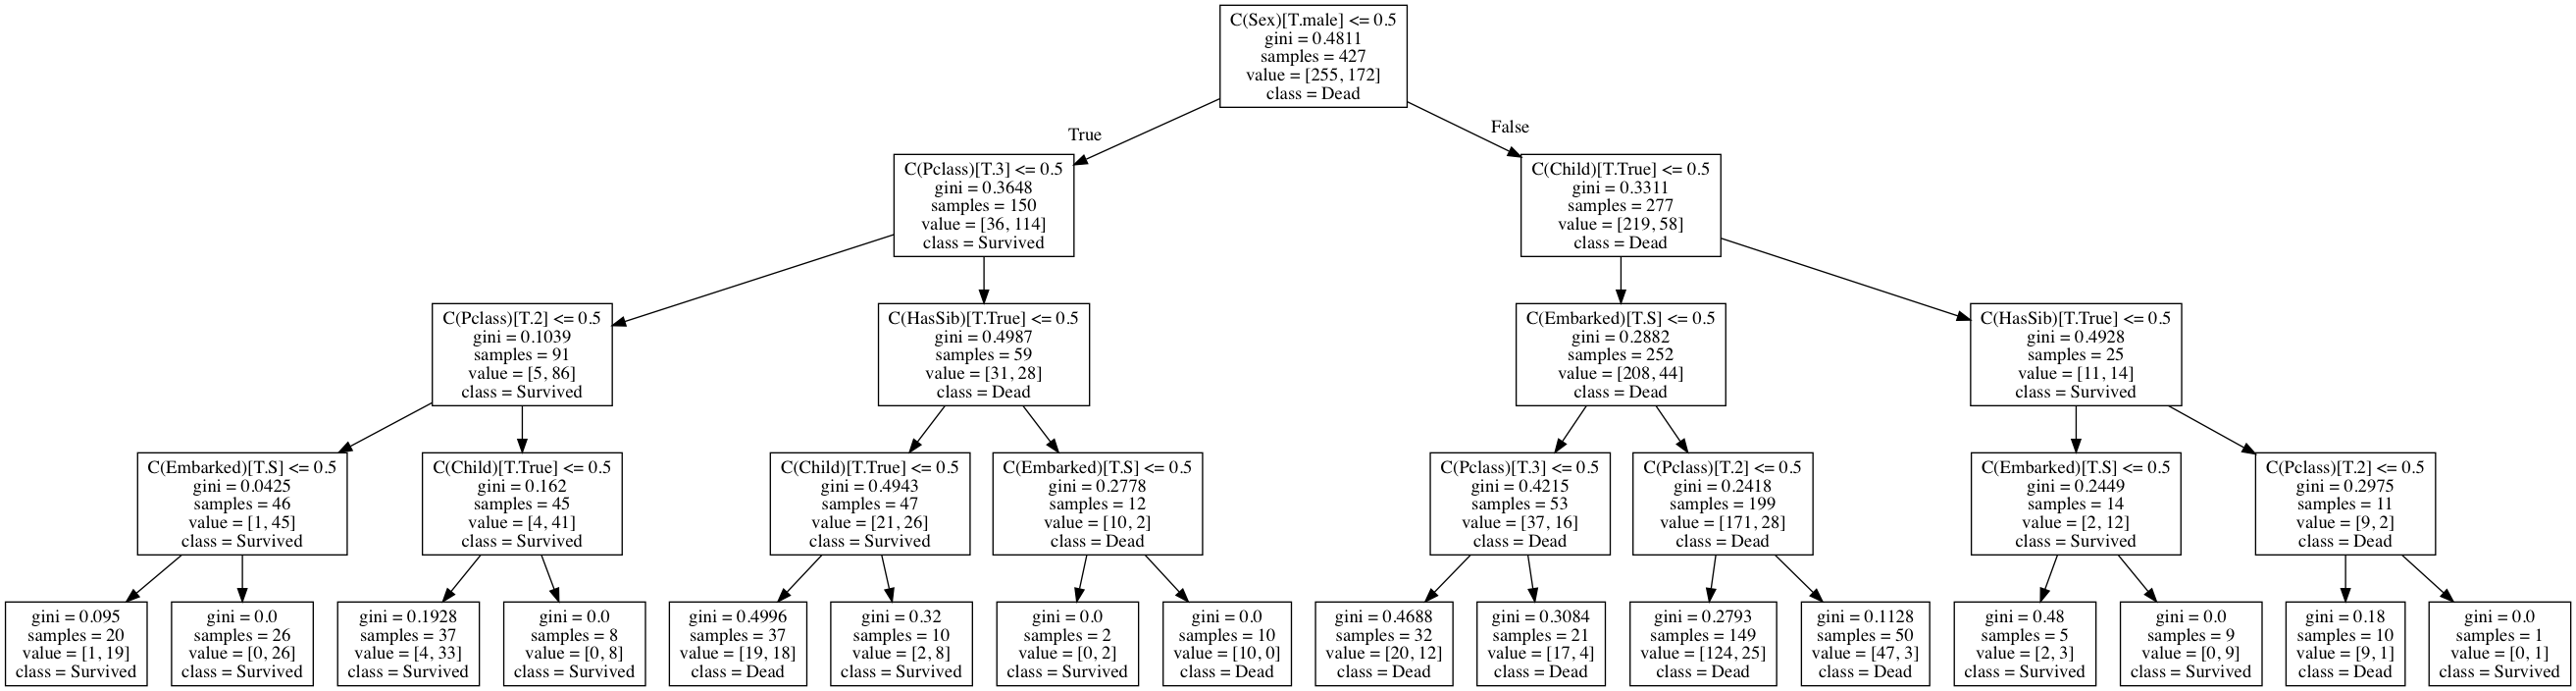

In [44]:
import patsy
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer

decision_tree_model = tree.DecisionTreeClassifier(max_depth=4)
decision_tree_model.fit(X_train, Y_train)

# 描画
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
tree.export_graphviz(
    decision_tree_model,
    out_file=dot_data,
    feature_names=list(X_train.keys()),
    class_names=['Dead', 'Survived']
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [45]:
predict = decision_tree_model.predict(X_test)
hit_rate(predict, Y_test) 

0.8280701754385965

In [41]:
output_result(decision_tree_model, test_data, titanic_test)
# 76.5

In [38]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=10, random_state=0)
random_forest_model.fit(X_train, Y_train)

predict_random_forest = random_forest_model.predict(X_test)
hit_rate(predict_random_forest, Y_test) 

0.8